In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

In [3]:
# Load the DataFrame from a pickle file
# df_cnn = pd.read_pickle('df_encoded.pkl')

df_cnn = pd.read_csv('../Data/encoded.csv')

# # Save the DataFrame to a CSV file
# df_cnn.to_csv('encoded.csv', index=False)

In [4]:
df_cnn.head()

,Age,Hours per day,BPM,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Gospel],Frequency [Hip hop],Frequency [Jazz],...,Fav genre_Rap,Fav genre_Rock,Fav genre_Video game music,Exploratory_No,Exploratory_Yes,Foreign languages_No,Foreign languages_Yes,Music effects_Improve,Music effects_No effect,Music effects_Worsen
0,-0.581585,0.095959,0.261316,0,0,3,0,0,1,1,...,0,0,1,1,0,0,1,0,1,0
1,3.101224,-0.391818,-1.191827,2,0,0,1,2,0,3,...,0,0,0,0,1,0,1,1,0,0
2,-0.581585,0.095959,-0.495529,0,0,1,0,1,3,0,...,0,0,0,0,1,1,0,1,0,0
3,-0.581585,0.421143,-1.131279,1,2,0,0,0,2,3,...,0,0,0,0,1,0,1,1,0,0
4,-0.581585,-0.229226,-1.736755,2,0,1,2,1,1,2,...,0,0,1,0,1,0,1,1,0,0


In [5]:
df_cnn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 58 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Age                                                          611 non-null    float64
 1   Hours per day                                                611 non-null    float64
 2   BPM                                                          611 non-null    float64
 3   Frequency [Classical]                                        611 non-null    int64  
 4   Frequency [Country]                                          611 non-null    int64  
 5   Frequency [EDM]                                              611 non-null    int64  
 6   Frequency [Folk]                                             611 non-null    int64  
 7   Frequency [Gospel]                                           611 non-null    int

In [6]:
print(df_cnn.shape[0])

611


In [7]:
print(df_cnn.columns)

Index(['Age', 'Hours per day', 'BPM', 'Frequency [Classical]',
       'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]',
       'Frequency [Gospel]', 'Frequency [Hip hop]', 'Frequency [Jazz]',
       'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]',
       'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]',
       'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]',
       'Anxiety', 'Depression', 'Insomnia', 'OCD',
       'Primary streaming service_Apple Music',
       'Primary streaming service_I do not use a streaming service.',
       'Primary streaming service_Other streaming service',
       'Primary streaming service_Pandora',
       'Primary streaming service_Spotify',
       'Primary streaming service_YouTube Music', 'While working_No',
       'While working_Yes', 'Instrumentalist_No', 'Instrumentalist_Yes',
       'Composer_No', 'Composer_Yes', 'Fav genre_Classical',
       'Fav genre_Country', 'Fav genre_EDM', 'Fav genre_Folk',

In [8]:
# Feature Engineering

# Selecting specific columns for genre frequencies from the dataframe
genres_freq_columns = df_cnn.iloc[:, 8:24]

# Combining other relevant columns for additional features
other_columns = pd.concat([df_cnn.iloc[:, :8], df_cnn.iloc[:, 24:28], df_cnn.iloc[:, 29:49]], axis=1)

# Selecting target columns related to music effects
target_columns = ['Music effects_Improve', 'Music effects_No effect', 'Music effects_Worsen']
target = df_cnn[target_columns]

# Dictionary to hold new interaction features
new_columns = {}

# Creating interaction features by multiplying each genre frequency with other feature columns
for genre_col in genres_freq_columns.columns:
    for other_col in other_columns.columns:
        new_columns[f'{genre_col}_x_{other_col}'] = genres_freq_columns[genre_col] * other_columns[other_col]

# Creating a DataFrame from the interaction features
feature_grid = pd.DataFrame(new_columns)

# Adding target columns to the feature grid
for col in target_columns:
    feature_grid[col] = target[col]

# Displaying the first few rows of the feature grid to verify
print(feature_grid.head())

# Printing the total number of rows to check the size of the feature grid
print("Total rows in feature grid:", feature_grid.shape[0])

   Frequency [Hip hop]_x_Age  Frequency [Hip hop]_x_Hours per day  \
0                  -0.581585                             0.095959   
1                   0.000000                            -0.000000   
2                  -1.744754                             0.287876   
3                  -1.163169                             0.842286   
4                  -0.581585                            -0.229226   

   Frequency [Hip hop]_x_BPM  Frequency [Hip hop]_x_Frequency [Classical]  \
0                   0.261316                                            0   
1                  -0.000000                                            0   
2                  -1.486588                                            0   
3                  -2.262558                                            2   
4                  -1.736755                                            2   

   Frequency [Hip hop]_x_Frequency [Country]  \
0                                          0   
1                         

In [9]:
# Grid Configuration

# Function to find factor pairs of a number that are closest to a square configuration
def find_factors_close_to_square(n):
    factors = [(i, n // i) for i in range(1, int(n**0.5) + 1) if n % i == 0]
    return sorted(factors, key=lambda x: abs(x[0]-x[1]))[0]

# Determine the number of features per depth dimension for the grid
grid_depth = len(other_columns.columns)

# Check if 512 features can be evenly distributed across the grid depth
if 512 % grid_depth == 0:
    sub_features = 512 // grid_depth 
    height, width = find_factors_close_to_square(sub_features)
    print(f"Suggested grid dimensions: Depth={grid_depth}, Height={height}, Width={width}")
else:
    print("Grid depth does not evenly divide into 512 features. Please reconsider grid depth.")

Suggested grid dimensions: Depth=32, Height=4, Width=4


In [10]:
# Assuming feature_grid is defined correctly up to this point with the right features
X = feature_grid.drop(['Music effects_Improve', 'Music effects_No effect', 'Music effects_Worsen'], axis=1).values
y = feature_grid[['Music effects_Improve', 'Music effects_No effect', 'Music effects_Worsen']].values

# Checking the shape of X to ensure it matches the desired reshape dimensions
print("Original X shape:", X.shape)

X_reshaped = X.reshape(-1, 32, 4, 4)

X_tensor = torch.tensor(X_reshaped, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Original X shape: (611, 512)


In [11]:
for data, target in train_loader:
    print("Data shape:", data.shape) 
    break

Data shape: torch.Size([64, 32, 4, 4])


In [12]:
class MusicEffectCNN(nn.Module):
    def __init__(self):
        super(MusicEffectCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.Tanh(),
#             nn.Sigmoid()
#             nn.LeakyReLU()

            nn.AdaptiveAvgPool2d(2) 
#             nn.MaxPool2d(2
#             nn.AvgPool2d
            
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 2 * 2, 128)  
        self.fc2 = nn.Linear(128, 3)
        
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [13]:
# class WeightedCrossEntropyLoss(nn.Module):
#     def __init__(self, weights):
#         super(WeightedCrossEntropyLoss, self).__init__()
#         self.weights = weights

#     def forward(self, inputs, targets):
#         ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
#         weighted_ce_loss = torch.mean(ce_loss * self.weights)
#         return weighted_ce_loss

In [14]:
# class FocalLoss(nn.Module):
#     def __init__(self, gamma=2, alpha=None):
#         super(FocalLoss, self).__init__()
#         self.gamma = gamma
#         self.alpha = alpha

#     def forward(self, inputs, targets):
#         ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
#         pt = torch.exp(-ce_loss)
#         focal_loss = ((1 - pt) ** self.gamma * ce_loss)
#         if self.alpha is not None:
#             focal_loss = self.alpha * focal_loss
#         return torch.mean(focal_loss)


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

# Assuming the class MusicEffectCNN is already defined
model = MusicEffectCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
# optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
# optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
criterion = nn.CrossEntropyLoss()
# weights = torch.tensor([0.5, 0.3, 0.2])
# loss_function = WeightedCrossEntropyLoss(weights)
# loss_function = FocalLoss(gamma=2, alpha=None)

num_epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_train_correct = 0
    total_train_samples = 0
    
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        
        if target.ndim > 1 and target.size(1) > 1:
            target_indices = torch.argmax(target, dim=1)
        else:
            target_indices = target

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target_indices)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output, 1)
        total_train_correct += (predicted == target_indices).sum().item()
        total_train_samples += data.size(0)
    
    avg_train_loss = total_train_loss / total_train_samples
    train_accuracy = total_train_correct / total_train_samples
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    model.eval()
    total_test_loss = 0
    total_test_correct = 0
    total_test_samples = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            
            if target.ndim > 1 and target.size(1) > 1:
                target_indices = torch.argmax(target, dim=1)
            else:
                target_indices = target

            output = model(data)
            loss = criterion(output, target_indices)
            total_test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            total_test_correct += (predicted == target_indices).sum().item()
            total_test_samples += data.size(0)
    
    avg_test_loss = total_test_loss / total_test_samples
    test_accuracy = total_test_correct / total_test_samples
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")



Epoch [1/50], Train Loss: 1.1908, Train Acc: 0.1660, Test Loss: 1.1823, Test Acc: 0.1545
Epoch [2/50], Train Loss: 1.1749, Train Acc: 0.1762, Test Loss: 1.1671, Test Acc: 0.1626
Epoch [3/50], Train Loss: 1.1597, Train Acc: 0.1844, Test Loss: 1.1522, Test Acc: 0.1870
Epoch [4/50], Train Loss: 1.1449, Train Acc: 0.1926, Test Loss: 1.1374, Test Acc: 0.2033
Epoch [5/50], Train Loss: 1.1303, Train Acc: 0.2131, Test Loss: 1.1230, Test Acc: 0.2114
Epoch [6/50], Train Loss: 1.1160, Train Acc: 0.2500, Test Loss: 1.1088, Test Acc: 0.2520
Epoch [7/50], Train Loss: 1.1019, Train Acc: 0.3238, Test Loss: 1.0949, Test Acc: 0.3496
Epoch [8/50], Train Loss: 1.0881, Train Acc: 0.3852, Test Loss: 1.0812, Test Acc: 0.4065
Epoch [9/50], Train Loss: 1.0744, Train Acc: 0.4221, Test Loss: 1.0677, Test Acc: 0.4959
Epoch [10/50], Train Loss: 1.0609, Train Acc: 0.5000, Test Loss: 1.0545, Test Acc: 0.5203
Epoch [11/50], Train Loss: 1.0477, Train Acc: 0.5533, Test Loss: 1.0413, Test Acc: 0.5528
Epoch [12/50], Trai

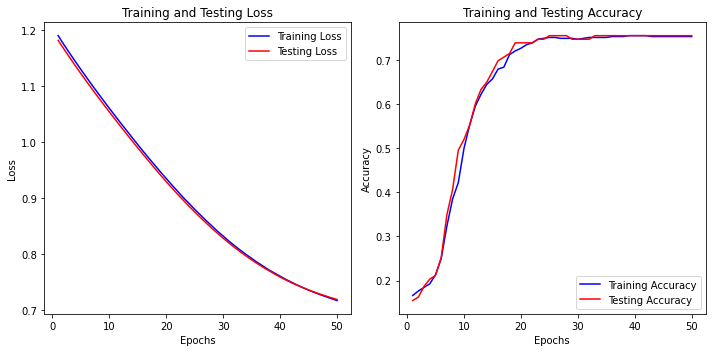

In [16]:
# Plotting the results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))

# Plotting training and testing losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, test_losses, 'r-', label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and testing accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'r-', label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



## Using K-fold

In [17]:
from sklearn.model_selection import KFold

# Assuming feature_grid is defined correctly up to this point with the right features
X = feature_grid.drop(['Music effects_Improve', 'Music effects_No effect', 'Music effects_Worsen'], axis=1).values
y = feature_grid[['Music effects_Improve', 'Music effects_No effect', 'Music effects_Worsen']].values

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Reshape X_train and X_test
    X_train_reshaped = X_train.reshape(-1, 32, 4, 4)
    X_test_reshaped = X_test.reshape(-1, 32, 4, 4)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    # Create train and test datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # Create train and test data loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Perform training and testing for this fold
    print(f"Fold {fold + 1}:")


Fold 1:
Fold 2:
Fold 3:
Fold 4:
Fold 5:


In [18]:
class MusicEffectCNN(nn.Module):
    def __init__(self):
        super(MusicEffectCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.Tanh(),
#             nn.Sigmoid()
#             nn.LeakyReLU()

            nn.AdaptiveAvgPool2d(2) 
#             nn.MaxPool2d(2
#             nn.AvgPool2d
            
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 2 * 2, 128)  
        self.fc2 = nn.Linear(128, 3)
        
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [19]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

# Assuming the class MusicEffectCNN is already defined
model = MusicEffectCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
# optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
# optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
criterion = nn.CrossEntropyLoss()
# weights = torch.tensor([0.5, 0.3, 0.2])
# loss_function = WeightedCrossEntropyLoss(weights)
# loss_function = FocalLoss(gamma=2, alpha=None)

num_epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_train_correct = 0
    total_train_samples = 0
    
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        
        if target.ndim > 1 and target.size(1) > 1:
            target_indices = torch.argmax(target, dim=1)
        else:
            target_indices = target

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target_indices)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output, 1)
        total_train_correct += (predicted == target_indices).sum().item()
        total_train_samples += data.size(0)
    
    avg_train_loss = total_train_loss / total_train_samples
    train_accuracy = total_train_correct / total_train_samples
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    model.eval()
    total_test_loss = 0
    total_test_correct = 0
    total_test_samples = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            
            if target.ndim > 1 and target.size(1) > 1:
                target_indices = torch.argmax(target, dim=1)
            else:
                target_indices = target

            output = model(data)
            loss = criterion(output, target_indices)
            total_test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            total_test_correct += (predicted == target_indices).sum().item()
            total_test_samples += data.size(0)
    
    avg_test_loss = total_test_loss / total_test_samples
    test_accuracy = total_test_correct / total_test_samples
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")



Epoch [1/50], Train Loss: 1.0996, Train Acc: 0.2781, Test Loss: 1.0890, Test Acc: 0.3525
Epoch [2/50], Train Loss: 1.0880, Train Acc: 0.3926, Test Loss: 1.0768, Test Acc: 0.4262
Epoch [3/50], Train Loss: 1.0767, Train Acc: 0.4744, Test Loss: 1.0650, Test Acc: 0.5410
Epoch [4/50], Train Loss: 1.0660, Train Acc: 0.5399, Test Loss: 1.0533, Test Acc: 0.5984
Epoch [5/50], Train Loss: 1.0551, Train Acc: 0.5869, Test Loss: 1.0419, Test Acc: 0.6475
Epoch [6/50], Train Loss: 1.0446, Train Acc: 0.6299, Test Loss: 1.0307, Test Acc: 0.6967
Epoch [7/50], Train Loss: 1.0341, Train Acc: 0.6524, Test Loss: 1.0198, Test Acc: 0.7049
Epoch [8/50], Train Loss: 1.0240, Train Acc: 0.6748, Test Loss: 1.0089, Test Acc: 0.7213
Epoch [9/50], Train Loss: 1.0139, Train Acc: 0.6830, Test Loss: 0.9982, Test Acc: 0.7541
Epoch [10/50], Train Loss: 1.0040, Train Acc: 0.6994, Test Loss: 0.9875, Test Acc: 0.7541
Epoch [11/50], Train Loss: 0.9945, Train Acc: 0.6994, Test Loss: 0.9769, Test Acc: 0.7541
Epoch [12/50], Trai

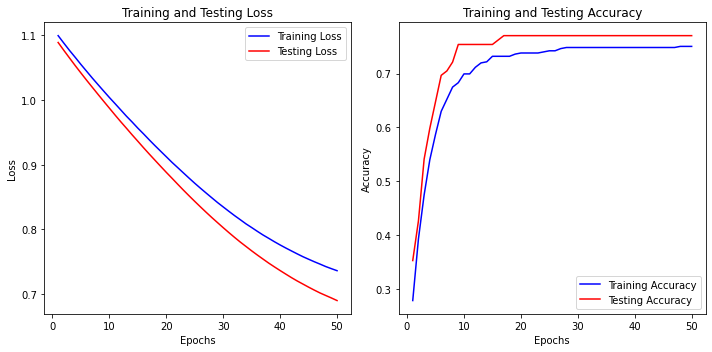

In [20]:
# Plotting the results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))

# Plotting training and testing losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, test_losses, 'r-', label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and testing accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'r-', label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
